In [594]:
from __future__ import division
import AudioLoad
import AudioFeatures
import AudioActDet
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import pandas as pd
%matplotlib inline
import math
import random
import sys
from numpy.linalg import inv

# Load Sound Track

In [595]:
reload(AudioLoad)

<module 'AudioLoad' from 'AudioLoad.pyc'>

In [596]:
AudioClass = AudioLoad.AudioLoad(Anal_Date = 'Apr-28-2017', Anal_Sample_Time=['1800Z'])

Analyzed File Type and Date: KJFK-Twr-Apr-28-2017
Duration of the sample audio: 1904.01
Sampling rate of the sample audio: 22050


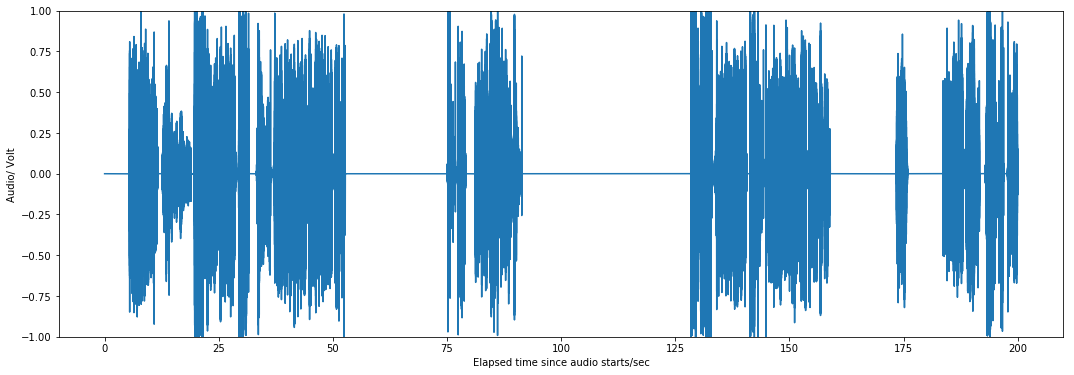

In [597]:
AudioClass.Visualizer(tmin = 0, tmax = 200)

# Feature Extraction

In [598]:
reload(AudioFeatures)

<module 'AudioFeatures' from 'AudioFeatures.pyc'>

In [6]:
FeatureClass = AudioFeatures.AudioFeatures(AudioLoad = AudioClass,
                                           nperseg = 512,
                                           overlap_rate = 8, 
                                           nfft = 1024, 
                                           fbank_hfreq = None,
                                           pre_emphasis = True)

In [7]:
features = FeatureClass.FeatureExtraction(highest_order = 2, 
                                          num_cep = 12, 
                                          lifting = True, 
                                          lifting_coef = 22, 
                                          mean_normalization = True, 
                                          nshift = 2)

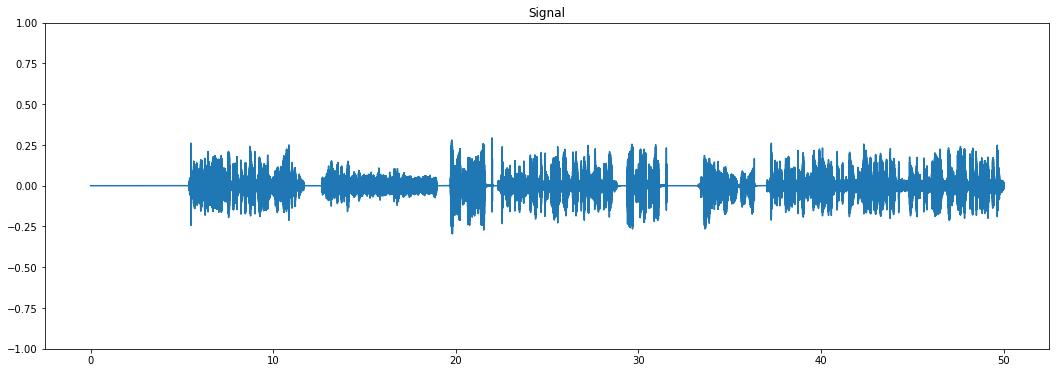

In [8]:
FeatureClass.Visualizer(item = 'signal', tmin = 0, tmax = 50)

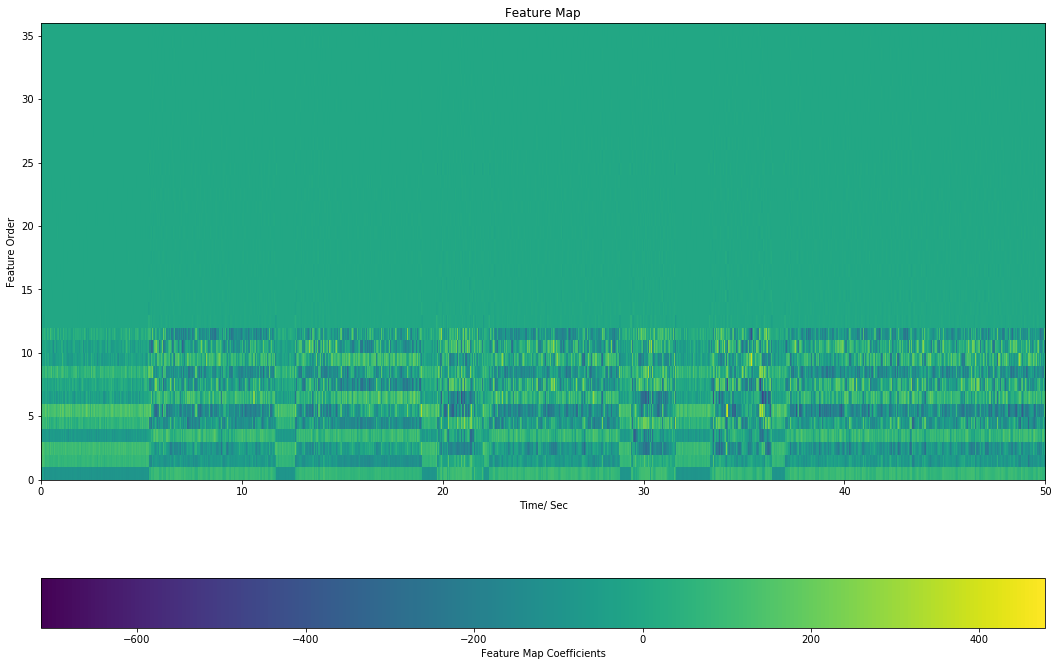

In [9]:
FeatureClass.Visualizer(item = 'features', tmin = 0, tmax = 50)

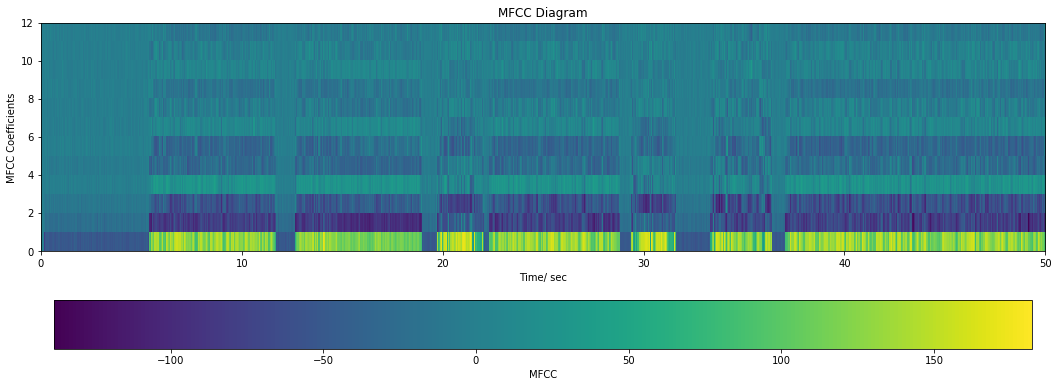

In [10]:
FeatureClass.Visualizer(item = 'mfcc', tmin = 0, tmax = 50)

AudioFeatures.py:192: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.flipud(10 * np.log10(self.Pxx[:, np.where((self.time_ins >= tmin) & (self.time_ins <= tmax))[0]])),


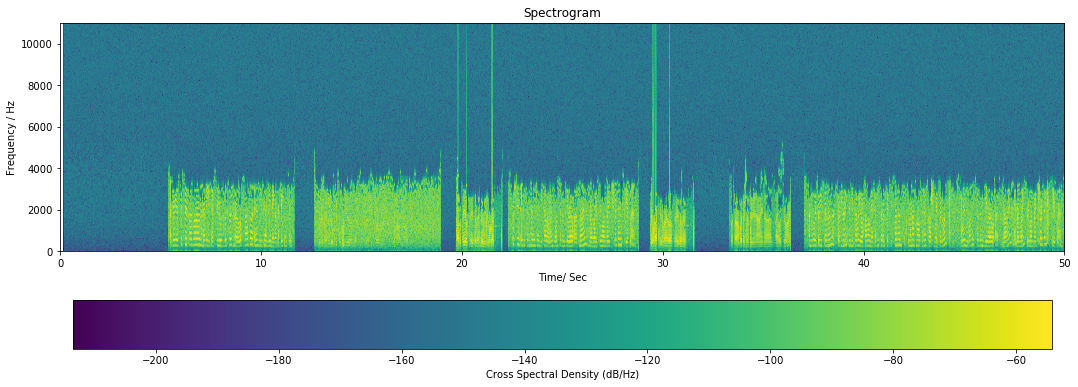

In [11]:
FeatureClass.Visualizer(item = 'spectrogram', tmin = 0, tmax = 50)

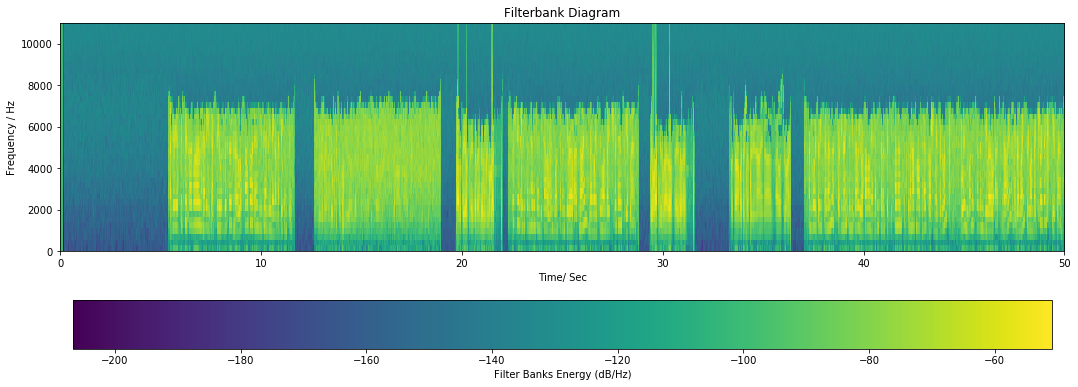

In [12]:
FeatureClass.Visualizer(item = 'filterbank', tmin = 0, tmax = 50)

# VAD

In [391]:
reload(AudioActDet)

<module 'AudioActDet' from 'AudioActDet.pyc'>

In [392]:
VADClass = AudioActDet.AudioActDet(FeatureClass)

In [517]:
sil_seg, silence_seg_2d, idx_act = VADClass.detect_silence(power_threshold = 0,
                                             silence_sec = 0.5, 
                                             mvg_point = 5)

In [61]:
idx_act

array([  264,   265,   266, ..., 93677, 93678, 93679])

In [63]:
features[:,idx_act].shape

(36, 51489)

# Audio Segmentation

In [16]:
import AudioSegmentation

In [17]:
reload(AudioSegmentation)

<module 'AudioSegmentation' from 'AudioSegmentation.pyc'>

In [18]:
SegClass = AudioSegmentation.AudioSegmentation(features[:, idx_act],
                                               VAD_removal = True)

In [67]:
min_wind = 200
inc_wind = 50
max_wind = 500
mov_frame = 10
mixture = False
Lambda = 1

In [68]:
def __helperSeg__(self, 
                  features, 
                  startFrame = 0, 
                  endFrame = 200,
                  incFrame = 10, 
                  mixture = False, 
                  Lambda = 1):
    analFrame = features[:, startFrame:endFrame]
    Nz = endFrame - startFrame
    if mixture:
        gmm = GaussianMixture(n_components = 2, random_state = 101).fit(analFrame.T)
        post_prob = gmm.predict_proba(analFrame.T)
        L0 = np.sum(np.log(post_prob.dot(gmm.weights_.reshape(2,1))))
    else:
        d = features.shape[0]
        L0 = np.sum(np.log(mvn.pdf(analFrame.T, mean = analFrame.mean(axis = 1), cov = np.cov(analFrame), allow_singular=True)))
        L0 += Lambda/2 * (d + d * (d + 1) / 2) * np.log(Nz)
        
    for Nx in range(startFrame + 2 * incFrame, endFrame - incFrame, incFrame):
        features_x = features[:, startFrame:Nx]
        features_y = features[:, Nx: endFrame]
        L1_x = np.sum(mvn.logpdf(features_x.T, mean = features_x.mean(axis = 1), cov = np.cov(features_x), allow_singular=True))
        L1_y = np.sum(mvn.logpdf(features_y.T, mean = features_y.mean(axis = 1), cov = np.cov(features_y), allow_singular=True))
        L1 = L1_x + L1_y
        if L1 - L0 >= 0:
            return Nx
    return -1

In [66]:
Seg = []
currentST = 0
currentET = min_wind
currentSize = currentET - currentST

In [19]:
st = time.time()
segments = SegClass.Segmentation(min_wind = 200,
                                     inc_wind = 50,
                                     max_wind = 500,
                                     mov_frame = 10,
                                     mixture = False,
                                     Lambda = 0.5)
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.01)
print(time.time() - st)

4.90444898605


In [20]:
gt = pd.read_csv(os.getcwd() + "/AudioDownload/Tower/GTResults.csv")
FAR, MDR, PRC, RCL, F, missed_id = SegClass.evalResult(gt)
print(FAR)
print(MDR)
print(PRC)
print(RCL)
print(F)

0.826543209877
0.0
0.173456790123
1.0
0.295633876907


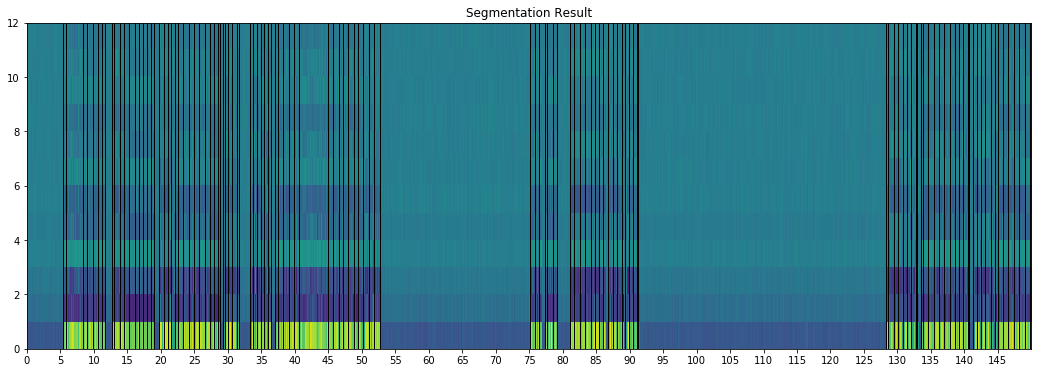

In [21]:
segTime, deadTime = SegClass.Visualizer(tmin = 0, 
                                        tmax = 150, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 5, 
                                        final = True)

In [22]:
pickle.dump(SegClass, open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'wb'), protocol=2)
pickle.dump(VADClass, open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'wb'), protocol=2)
pickle.dump(FeatureClass, open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'wb'), protocol=2)
pickle.dump(AudioClass, open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'wb'), protocol=2)

# Analize from the previous run

In [23]:
SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))

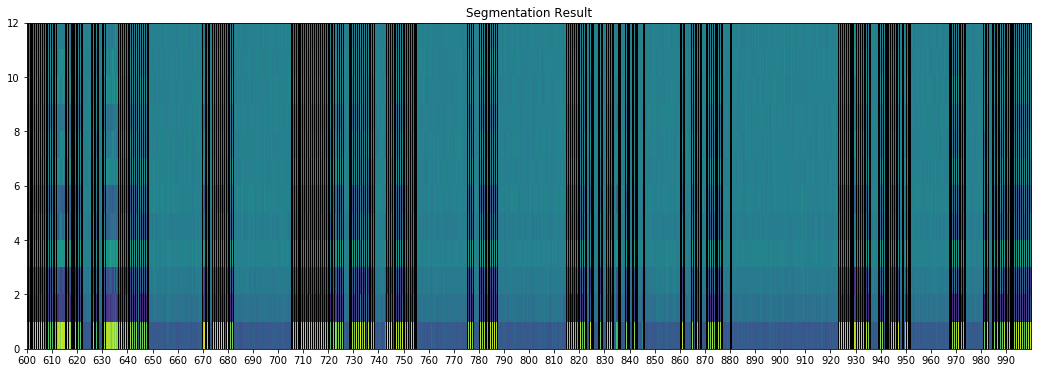

In [24]:
segTime, deadTime = SegClass.Visualizer(tmin = 600, 
                                        tmax = 1000, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 10, 
                                        final = True)

In [518]:
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.01)

In [553]:
SegIdx2d[0:21]

array([[ 263,  574],
       [ 621,  912],
       [ 912,  933],
       [ 967, 1107],
       [1107, 1397],
       [1397, 1417],
       [1443, 1555],
       [1641, 1791],
       [1821, 1832],
       [1832, 2452],
       [2452, 2596],
       [3697, 3893],
       [3992, 4004],
       [4004, 4234],
       [4234, 4490],
       [6316, 6321],
       [6321, 6541],
       [6541, 6542],
       [6573, 6913],
       [6913, 6926],
       [6956, 7134]])

In [613]:
act_segs = []
for i in SegIdx2d:
    if i[1] - i[0] > 1:
        act_seg = features[:,i[0]:i[1]]
        act_segs.append(act_seg)
    else:
        print ('Remove' + str(i)) 

Remove[6541 6542]


In [614]:
def single_gau(matrix):
    cov=np.var(matrix,1)
    det = 0
    for i in range(len(cov)):
        det = det + math.log(cov[i])
    return det

In [615]:
def bicdist(x,y,lf):
    # lf is lambda which is free design para. dependent on the data
    z=np.concatenate((x,y),axis=1)
    xn = x.shape[1]
    yn = y.shape[1]
    zn = z.shape[1]
    
    p = 0.5*(d+0.5*d*(d+1))*(math.log(zn))
    r = zn * single_gau(z)- xn * single_gau(x) - yn * single_gau(y)
    bic= r - p*lf

    return bic

In [616]:
act_segs = act_segs[0:20]

In [617]:
count = 0
bic = -0.01
lf = 1
print(str(len(act_segs))+' Clusters ')
count1 = 0
bicact = []
tslin = []
diry_dist = {}

20 Clusters 


In [618]:
while((len(act_segs)>1)&(bic<0)):
    si_idx =[]
    sj_idx=[]
    dist=[]
    
    ## Update clusters
    if(count1 == 0):
        act_segs = act_segs
    else:
        act_segs = new_clus
        diry_dist = new_diry
        
    for i in range(len(act_segs)-1):
        for j in range(i+1, len(act_segs)):
            pair = str(i)+'_'+str(j)
            
            ## Avoid repeat calculation
            if pair in diry_dist:
                dist.append(diry_dist[pair])
            else:
                caldist = bicdist(act_segs[i],act_segs[j], lf)
                diry_dist.update({pair:caldist})
                dist.append(diry_dist[pair])
            si_idx.append(i)
            sj_idx.append(j)
        count = count + 1 
    if (len(dist) == 0):
        break
    
    # Merge!
    # 找出bic最小 －> bic 最小的index -> 从index找原来的元素
    bic = min(dist)
    #print ('BIC SCORE' + str(bic))
    bicact.append(bic)
    minbic_idx = dist.index(bic)
    s1 = si_idx[minbic_idx]
    s2 = sj_idx[minbic_idx]
    print('Merge: '+ str (s1) + ' & ' + str(s2))
    merge_clus = np.concatenate((act_segs[s1], act_segs[s2]), axis = 1)
    #print('Shape' + str(merge_clus.shape))
    
    # Update clusters
    new_clus = []
    new_diry = {}
    for k in range(0, len(act_segs)):
        if((k!=s1) & (k!=s2)):
            new_clus.append(act_segs[k])    # 照搬抽去s1 s2后剩下的clusters
    new_clus.append(merge_clus)             # merge后的新cluster加在末尾   
    

    # Update distance ditionary
    for m in range(0, len(act_segs)-1):
        for n in range(m+1, len(act_segs)):
            pair = str(m) + '_'+str(n)
            # 除去已经抽出来的s1, s2
            con = not ((m==s1) or (m==s2) or(n==s1)or(n==s2))
            if (con):
                if ((m<s1)and(n<s1)):
                    str1 = str(m)+'_' + str(n)
                    new_diry.update({str1:diry_dist[pair]})
                elif((m<s1)and(n>s1)and(n<s2)):
                    str1=str(m)+'_'+str(n-1)
                    new_diry.update({str1:diry_dist[pair]})
                elif((m<s1)and(n>s2)):
                    str1=str(m)+'_'+str(n-2)
                    new_diry.update({str1:diry_dist[pair]})
                elif((m>s1)and(n<s2)):
                    str1=str(m-1)+'_'+str(n-1)
                    new_diry.update({str1:diry_dist[pair]})
                elif((m>s1)and(n>s2)and(m<s2)):
                    str1=str(m-1)+'_'+str(n-2)
                    new_diry.update({str1:diry_dist[pair]})
                elif((m>s2)and(n>s2)):
                    str1=str(m-2)+'_'+str(n-2)
                    new_diry.update({str1:diry_dist[pair]})
                else:
                    print('error in indexing')
                    print(str(s1)+' '+str(s2)+' m/n=> '+str(m)+' '+str(n))
                    #print(con)
    count1=count1+1
    print('-------Clusters Remain '+str(len(act_segs)))

Merge: 4 & 9
-------Clusters Remain 20
Merge: 15 & 18
-------Clusters Remain 19
Merge: 4 & 17
-------Clusters Remain 18
Merge: 14 & 16
-------Clusters Remain 17
Merge: 6 & 15
-------Clusters Remain 16
Merge: 2 & 14
-------Clusters Remain 15
Merge: 0 & 13
-------Clusters Remain 14
Merge: 6 & 12
-------Clusters Remain 13
Merge: 8 & 11
-------Clusters Remain 12
Merge: 8 & 9
-------Clusters Remain 11
Merge: 2 & 9
-------Clusters Remain 10
Merge: 1 & 8
-------Clusters Remain 9
Merge: 2 & 7
-------Clusters Remain 8
Merge: 1 & 6
-------Clusters Remain 7
Merge: 3 & 5
-------Clusters Remain 6
Merge: 1 & 4
-------Clusters Remain 5
Merge: 0 & 2
-------Clusters Remain 4
Merge: 0 & 1
-------Clusters Remain 3
Merge: 0 & 1
-------Clusters Remain 2


In [612]:
act_segs[0].shape

(36, 1934)

In [30]:
import AudioCluster

In [31]:
reload(AudioCluster)

<module 'AudioCluster' from 'AudioCluster.pyc'>

In [32]:
AudioClusterClass = AudioCluster.AudioCluster(SegIdx2d, features)

In [67]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [101]:
testClusterDB = DBSCAN(eps = 700, min_samples = 2, metric = 'precomputed')
testClusterDB.fit(np.sqrt(pd**2))
testClusterDB.labels_ 

array([-1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  1,  3, -1, -1,  3, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  3, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  3, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        3, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1,  1,
       -1, -1], dtype=int

In [64]:
testCluster = AgglomerativeClustering(n_clusters = 100, affinity = 'precomputed', linkage='average')

In [65]:
testCluster.fit(pd)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=100,
            pooling_func=<function mean at 0x0000000002501128>)

In [66]:
testCluster.labels_

array([ 4,  0,  0,  0,  0,  0,  0, 90, 85,  0,  0,  0,  0,  0,  0,  9,  0,
       55,  0,  0,  0,  0, 77,  0, 81, 52,  0, 84,  8,  0, 17, 59, 94,  0,
        0, 57, 20, 22,  0, 62,  0, 17,  4, 50, 61, 60,  0, 80, 58,  0,  0,
        0, 56,  0,  0,  0,  0, 11, 28, 73, 51, 89,  0,  0,  5,  0, 87,  0,
       72, 79, 22, 86,  3, 76, 92,  0, 69,  0, 71, 10,  0,  0,  0,  0,  8,
        0,  0, 75,  3, 27, 29, 67, 37, 65, 95, 91, 30, 63, 78,  0, 39,  7,
       66,  0,  0, 93,  5,  0,  0, 97,  0, 20, 54,  0,  0, 64,  0, 13,  7,
        0, 31, 83,  0,  0,  0,  0,  0,  0,  0, 41, 98,  0,  2, 35,  0, 32,
        0, 25,  0,  0,  0,  0, 99, 24,  0,  0,  9,  0,  0,  0, 88,  0, 96,
       42,  0,  0, 14,  0,  0,  0, 82, 49,  0,  0, 10, 70, 53, 47,  0, 74,
       11,  0,  0, 38, 40,  0,  0,  0, 45, 68,  6,  1, 26,  0, 24,  0, 36,
        0,  0, 12, 15, 44,  0,  0,  0,  0,  0, 34, 43, 21, 48,  1,  0,  0,
       46, 19,  0,  0,  0,  0,  0,  0,  0, 33,  0, 18,  0,  0,  2,  0, 23,
       16,  0], dtype=int

In [3]:
# SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
# VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
# FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
# AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))